# Session 4: YOLO for Object Detection

## YOLOv1 Implementation from Scratch

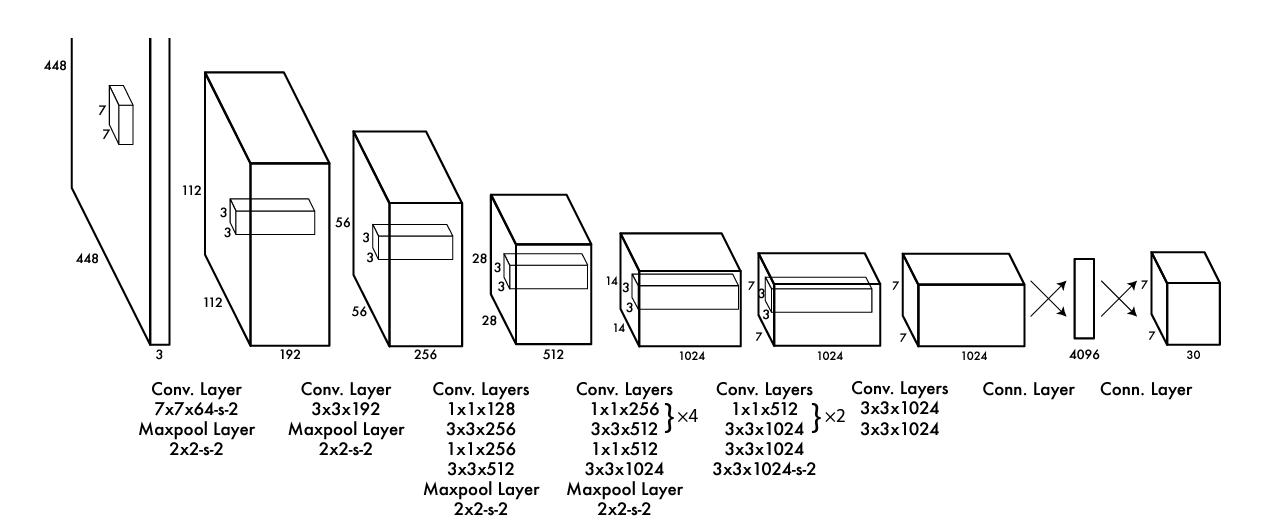

## DEMO: YOLO and OpenCV for Object Detection

Importing OpenCV library (cv2) for image processing and numpy for numerical operations.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Load the YOLOv3 model. cv2.dnn.readNet loads the network from two files: the weights file (yolov3.weights) and the configuration file (yolov3.cfg). net.getLayerNames() retrieves the names of all layers in the network, and net.getUnconnectedOutLayers() gets the indices of the output layers.

In [5]:
# Load YOLO
net = cv2.dnn.readNet("./ressources/yolov3.weights", "./ressources/yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [6]:
# Load coco names (class labels)
classes = []
with open("./ressources/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

Load an image, and then resize it to 40% of its original size using cv2.resize. It also retrieves the dimensions of the image (height, width, and number of channels).

In [7]:
img = cv2.imread("./ressources/baggio_10_it.jpg")
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

This section prepares the image for input to the neural network. cv2.dnn.blobFromImage converts the image into a blob format suitable for the network. It normalizes the values, resizes the image to (416, 416), and sets various parameters.
net.setInput(blob) sets the input of the network to the prepared image.

net.forward(output_layers) passes the input through the network and retrieves the output from the specified output layers.

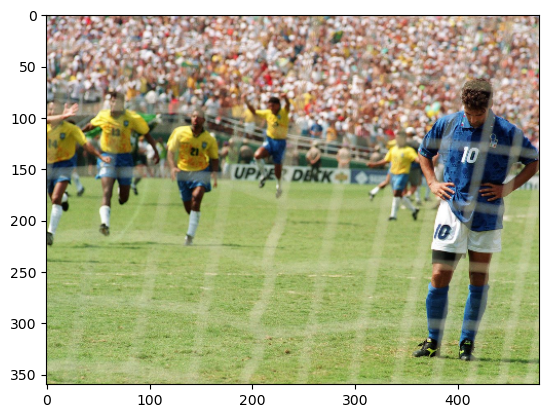

In [8]:
# Convert BGR image to RGB (Matplotlib uses RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)

In [9]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

This loop processes the output of the YOLO network. It iterates through each output layer and each detection in the output. It extracts information about the detected objects such as class scores, confidence, and bounding box coordinates. If the confidence is greater than 0.5, it considers the detection.

In [10]:
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


This line performs Non-Maximum Suppression (NMS) to remove redundant overlapping bounding boxes.

In [11]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

These lines define the font and generate random colors for class labels.


In [12]:
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(len(classes), 3))

This loop iterates through the detected boxes after NMS and draws bounding boxes and class labels on the image.

In [13]:
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)


These lines display the image with the detected objects, waits for a key press, and then closes the window.

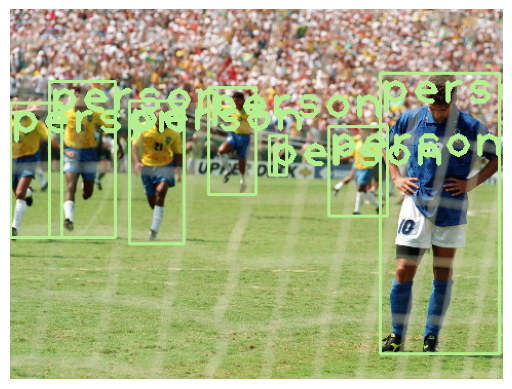

In [14]:
# Convert BGR image to RGB (Matplotlib uses RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## DEMO 3: Detect Chest Diseases using YOLOv5

<b>Source:</b> https://www.exxactcorp.com/blog/Deep-Learning/YOLOv5-PyTorch-Tutorial

The main goal of the example in this demo is to use the YOLO algorithm to detect a list of chest diseases in a given image. As with any machine learning model, we will run ours using thousands of chest-scanned images. The goal is for the YOLO algorithm to successfully detect all lesions in the given image. 

<b>Dataset: </b>The  VinBigData 512 image Dataset (https://www.kaggle.com/datasets/awsaf49/vinbigdata-512-image-dataset). The data set is divided into two parts, the training, and the testing data sets. The training data set contains 15,000 images, while the testing data set contains 3,000. This division of data between the training and the testing is somehow optimal as the training data set is usually 4 to 5 times the size of the testing data set.  

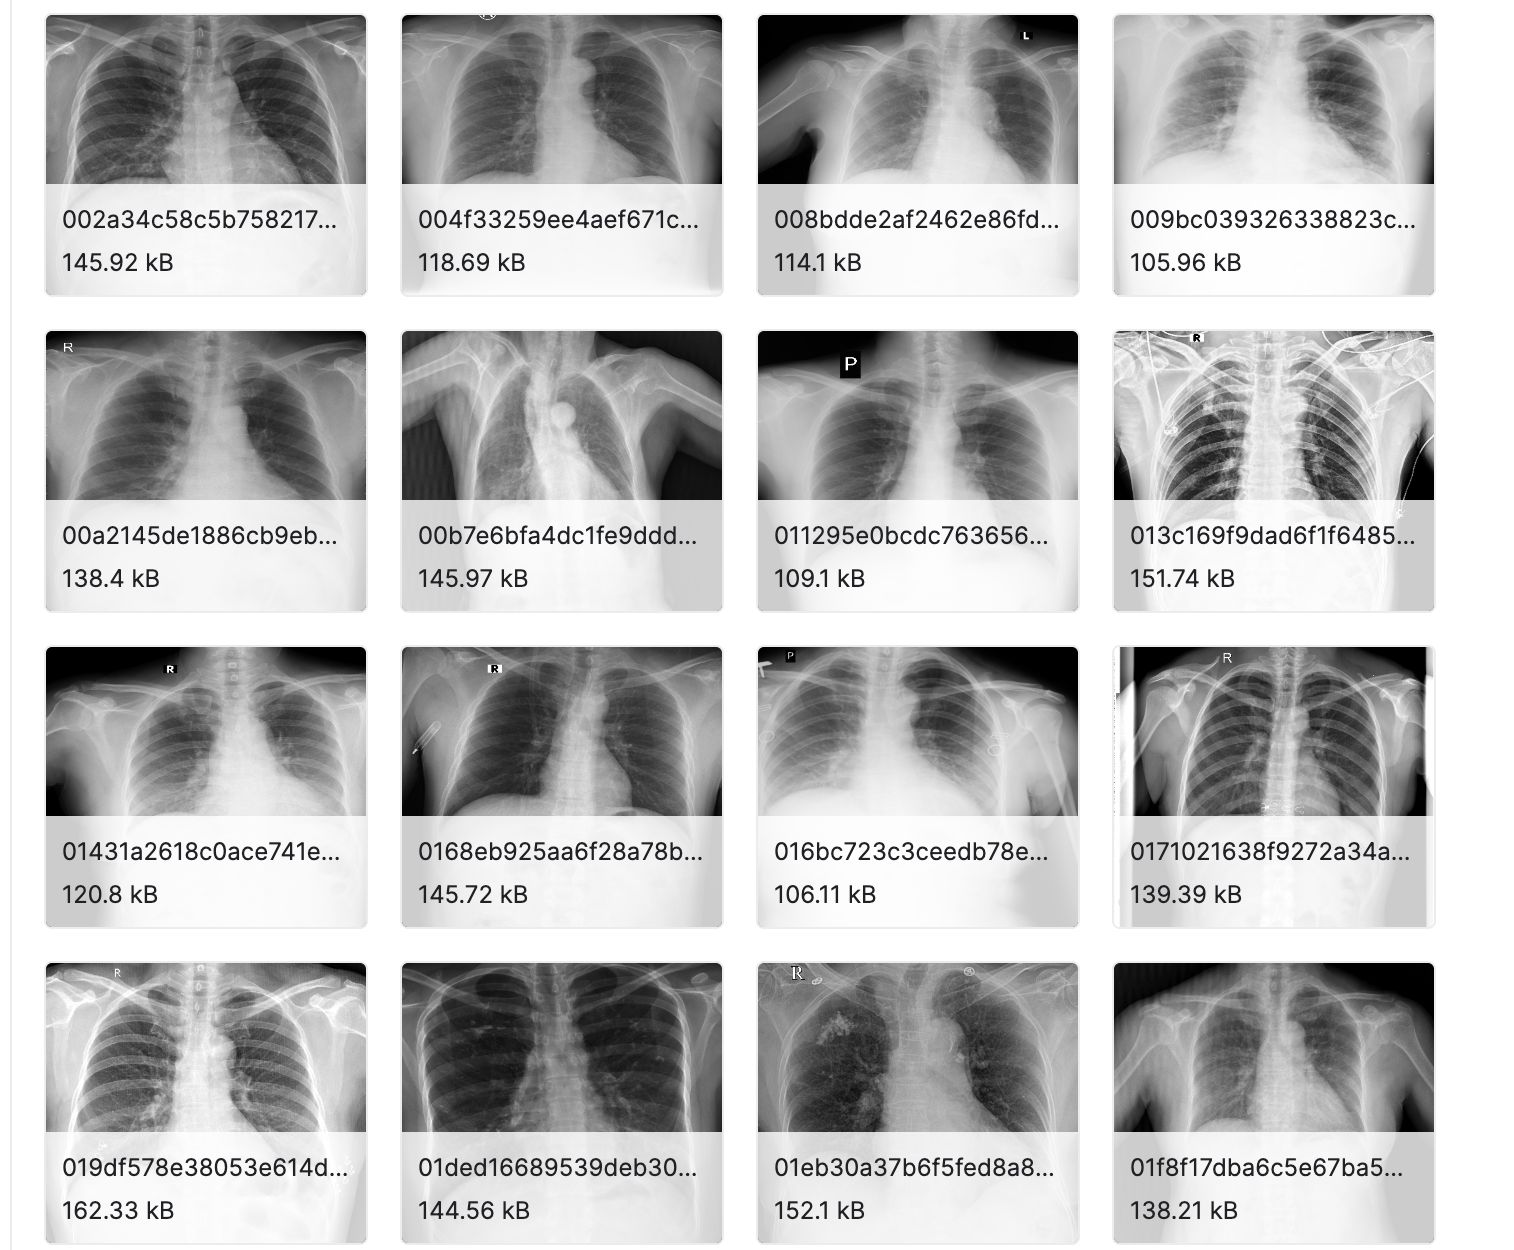

The other part of the data set contains the label for all the images. Inside this data set each image is labeled with a class name (chest disease found), along with the class ID, width and height of the image, etc. Check the below image to view all the columns available. 

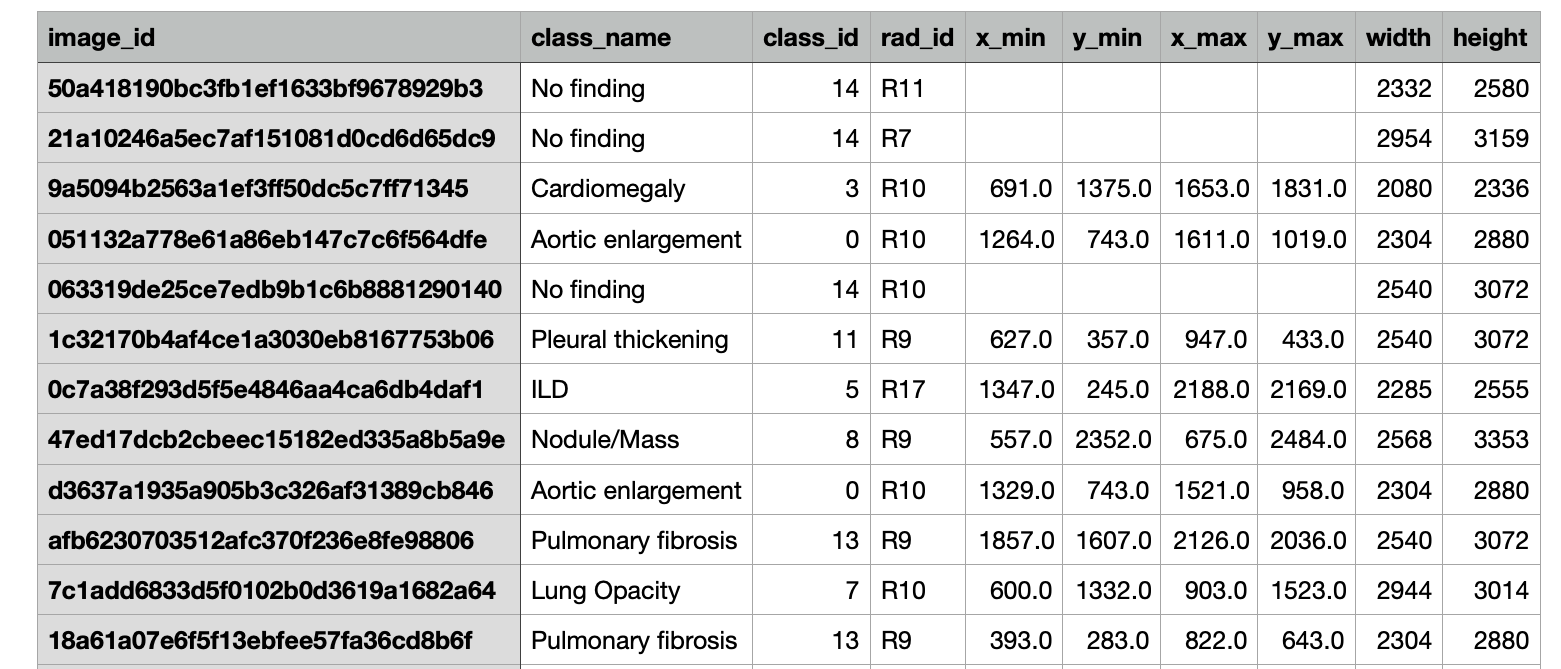

In [7]:
# Importing Libraries
import pandas as pd
import os
import numpy as np
import shutil
import ast
from sklearn import model_selection
from tqdm import tqdm
import wandb
from sklearn.model_selection import GroupKFold
from IPython.display import Image, clear_output  # to display images
from os import listdir
from os.path import isfile
from glob import glob
import yaml
# clear_output()

In [12]:
TRAIN_LABELS_PATH = './VinBigData 512 image Dataset/labels/train'
VAL_LABELS_PATH = './VinBigData 512 image Dataset/labels/val'
TRAIN_IMAGES_PATH = './VinBigData 512 image Dataset/images/train' #12000
VAL_IMAGES_PATH = './VinBigData 512 image Dataset/images/val' #3000
External_DIR = './VinBigData 512 image Dataset' # 15000
os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)
size = 512

In [13]:
df = pd.read_csv('./VinBigData 512 image Dataset/train.csv')
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


As no data set is perfect, most of the time a filtering process is necessary to optimize a data set, thus optimizing our model’s performance. In this step, we would drop any row with a class id that is equal to 14. 

This class id stands for a no finding in the disease class. The reason we dropped this class is that it may confuse our model. Moreover, it will slow it down because our data set will be slightly bigger.

In [14]:
df = df[df.class_id!=14].reset_index(drop = True)

In [15]:
# Calculating the Coordinates of the Bounding Box for YOLO

In [16]:
df['x_min'] = df.apply(lambda row: (row.x_min)/row.width, axis = 1)*float(size)
df['y_min'] = df.apply(lambda row: (row.y_min)/row.height, axis = 1)*float(size)
df['x_max'] = df.apply(lambda row: (row.x_max)/row.width, axis =1)*float(size)
df['y_max'] = df.apply(lambda row: (row.y_max)/row.height, axis =1)*float(size)

df['x_mid'] = df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

df['w'] = df.apply(lambda row: (row.x_max-row.x_min), axis =1)
df['h'] = df.apply(lambda row: (row.y_max-row.y_min), axis =1)

df['x_mid'] /= float(size)
df['y_mid'] /= float(size)

df['w'] /= float(size)
df['h'] /= float(size)

In [18]:
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,170.092308,301.369863,406.892308,401.315068,2080,2336,0.563462,0.686216,0.462500,0.195205
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,280.888889,132.088889,358.000000,181.155556,2304,2880,0.623915,0.305903,0.150608,0.095833
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,126.387402,59.500000,190.891339,72.166667,2540,3072,0.309843,0.128581,0.125984,0.024740
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,301.822319,49.095890,490.265208,434.648924,2285,2555,0.773523,0.472407,0.368053,0.753033
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,111.052960,359.148225,134.579439,379.304503,2568,3353,0.239875,0.721145,0.045950,0.039368


In [19]:
# cross validation
gkf  = GroupKFold(n_splits = 5)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups = df.image_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
val_df = df[df['fold']==4]
val_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h,fold
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,126.387402,59.500000,190.891339,72.166667,2540,3072,0.309843,0.128581,0.125984,0.024740,4
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,111.052960,359.148225,134.579439,379.304503,2568,3353,0.239875,0.721145,0.045950,0.039368,4
12,fb8e11c6b2886b2d41b379e0598669b9,Aortic enlargement,0,R10,308.888889,156.088889,359.111111,206.755556,2304,2880,0.652344,0.354340,0.098090,0.098958,4
13,0622cd29e4e0e4f198abf15614819ae8,Cardiomegaly,3,R10,215.622428,302.336574,433.310206,377.394166,2479,2674,0.633723,0.663800,0.425171,0.146597,4
14,347180362348e522905047dde655b6d7,Pleural thickening,11,R9,288.750000,41.779200,353.500000,54.886400,2048,2500,0.627197,0.094400,0.126465,0.025600,4
